In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda,MaxPool2D
from keras.layers.merge import concatenate
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import imgaug as ia
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
img_width, img_height = 250, 350 #
train_data_dir = r'../input/cartoon-classification/cartoon_classification/TRAIN'
validation_data_dir = r'../input/cartoon-classification/cartoon_classification/TEST/'

batch_size = 32
channels=3
num_classes=10


train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 119617 images belonging to 10 classes.
Found 18110 images belonging to 10 classes.


In [6]:
input = Input(shape=(img_height, img_width, channels))


# Block 1
layer0 = Conv2D(32, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(input)
layer0 = Activation('relu')(layer0)
layer0 = BatchNormalization()(layer0)


# Block 2

layer1 = Conv2D(128, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer0)
layer1 = Activation('relu')(layer1)
layer1 = BatchNormalization()(layer1)

layer2 = Conv2D(128, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer1)
layer2 = Activation('relu')(layer2)
layer2 = BatchNormalization()(layer2)

layer3 = MaxPooling2D(pool_size=(2, 2))(layer2)
layer3 = Dropout(0.2)(layer3)

# Block 3

layer4 = Conv2D(256, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer3)
layer4 = Activation('relu')(layer4)
layer4 = BatchNormalization()(layer4)

layer5 = Conv2D(256, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer4)
layer5 = Activation('relu')(layer5)
layer5 = BatchNormalization()(layer5)

layer6 = MaxPooling2D(pool_size=(2, 2))(layer5)
layer6 = Dropout(0.2)(layer6)

# Block 4

layer7 = Conv2D(512, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer6)
layer7 = Activation('relu')(layer7)
layer7 = BatchNormalization()(layer7)

layer8 = Conv2D(512, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer7)
layer8 = Activation('relu')(layer8)
layer8 = BatchNormalization()(layer8)

layer9 = MaxPooling2D(pool_size=(2, 2))(layer8)
layer9 = Dropout(0.2)(layer9)

layer10 = Conv2D(num_classes, (1,1), padding='same',kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer9)
# Apply global average pooling to get flat feature vectors
layer10 = GlobalAveragePooling2D()(layer10)


#Output Layer
output = Dense(num_classes, activation="softmax")(layer10)



2022-03-15 19:11:50.041487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 19:11:50.138540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 19:11:50.139314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 19:11:50.140926: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 350, 250, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 350, 250, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 350, 250, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 350, 250, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 350, 250, 128)     36992     
_________________________________________________________________
activation_1 (Activation)    (None, 350, 250, 128)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 350, 250, 128)     512   

In [8]:
callback_list = [
      ModelCheckpoint(
        filepath='./weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
        monitor='val_accuracy',
        verbose=1,
        mode='max',
        save_best_only=True)
]

In [9]:
# Compile the Model
model.compile(loss='categorical_crossentropy',
              #optimizer= RMSprop(lr= 0.0001, epsilon=1e-08),
              #optimizer= Adam(lr= 0.0001, epsilon=1e-08),
              optimizer = SGD(lr = 0.001, momentum=0.9),
              metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
hist = model.fit_generator(
        generator=train_generator,
        steps_per_epoch = 1500,
        epochs=10,
        validation_data=validation_generator,
        validation_steps = 220,
        shuffle=True,
        callbacks=callback_list
        )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-03-15 19:11:53.487605: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-15 19:11:56.646014: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1500/1500 [==============================] - 2026s 1s/step - loss: 0.7335 - accuracy: 0.8952 - val_loss: 1.0407 - val_accuracy: 0.7616

Epoch 00001: val_accuracy improved from -inf to 0.76165, saving model to ./weights-01-0.762.hdf5
Epoch 2/10
1500/1500 [==============================] - 1928s 1s/step - loss: 0.4621 - accuracy: 0.9740 - val_loss: 0.9212 - val_accuracy: 0.8416

Epoch 00002: val_accuracy improved from 0.76165 to 0.84162, saving model to ./weights-02-0.842.hdf5
Epoch 3/10
1500/1500 [==============================] - 1909s 1s/step - loss: 0.4195 - accuracy: 0.9841 - val_loss: 1.1474 - val_accuracy: 0.7982

Epoch 00003: val_accuracy did not improve from 0.84162
Epoch 4/10
1500/1500 [==============================] - 1864s 1s/step - loss: 0.3941 - accuracy: 0.9901 - val_loss: 1.0752 - val_accuracy: 0.8200

Epoch 00004: val_accuracy did not improve from 0.84162
Epoch 5/10
1500/1500 [==============================] - 1869s 1s/step - loss: 0.3819 - accuracy: 0.9926 - val_loss: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


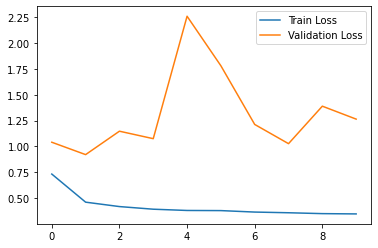

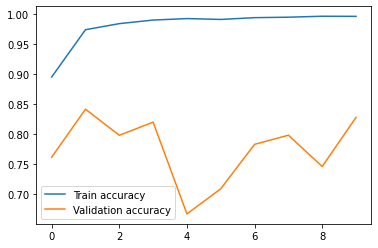

In [11]:
print(hist.history.keys())

plt.plot(hist.history["loss"], label ="Train Loss")
plt.plot(hist.history["val_loss"], label ="Validation Loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(hist.history["accuracy"], label ="Train accuracy")
plt.plot(hist.history["val_accuracy"], label ="Validation accuracy")
plt.legend()
plt.show()